<a href="https://colab.research.google.com/github/Crall-Lab/SICB2025_CV/blob/activity_testing/deepLearningNotebooks/1_training/SICB2025_objDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Crall-Lab/SICB2025_CV.git -b activity_testing

Cloning into 'SICB2025_CV'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 288 (delta 55), reused 14 (delta 14), pack-reused 177 (from 1)
Receiving objects: 100% (288/288), 142.02 MiB | 25.49 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [ ]:
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms0.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms1.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms2.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms3.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms4.zip
!unzip /content/SICB2025_CV/deepLearningNotebooks/1_training/trainIms5.zip


In [16]:
import glob
import os
import shutil

getFolds = glob.glob('/content/content/train_*/*')
for ele in getFolds:
  if os.path.isdir('/content/trainIms/'+ele.split('/')[-1]) == False:os.makedirs('/content/trainIms/'+ele.split('/')[-1])


getFiles = glob.glob('/content/content/train_*/*/*')

for ele in getFiles:
  tempFile = '/content/trainIms/'+ele.split('/')[-2]+'/'+ele.split('/')[-1]
  shutil.copyfile(ele,tempFile)

!rm /content/content/ -r

In [ ]:
if os.path.isdir('/content/trainIms/') is False:
  os.mkdir('/content/trainIms/')

x1 = rr['0.23'].values
y1 = rr['0.03284072249589491'].values
x2 = rr['0.71625'].values
y2 = rr['0.9917898193760263'].values

annotations = {}

for ind1,ele1 in enumerate(paths):
  ele = ele1.split('/')[-2]
  if ele in clss:

    if os.path.isdir('/content/trainIms/'+ele+'/') is False:os.mkdir('/content/trainIms/'+ele+'/')
    tempPath = '/content/trainIms/'+ele+'/'+ele1.split('/')[-1]
    ts = '/content/trainIms/'+ele+'/*'
    if len(glob.glob(ts)) < 25:
      shutil.copyfile(ele1,tempPath)

      if tempPath not in annotations:annotations[tempPath] = []
      cntrx = (x1[ind1]+x2[ind1])/2
      cntry = (y1[ind1]+y2[ind1])/2
      width = x2[ind1]-x1[ind1]
      height = y2[ind1]-y1[ind1]
      temps = []
      annotations[tempPath].append([cntrx,cntry,width,height])
      #if len(annotations[tempPath])>1:print(tempPath)

annotationsV = {}

for ind1,ele1 in enumerate(paths):
  ele = ele1.split('/')[-2]
  if ele in clss:

    if os.path.isdir('/content/valIms/'+ele+'/') is False:os.makedirs('/content/valIms/'+ele+'/')
    tempPath = '/content/valIms/'+ele+'/'+ele1.split('/')[-1]
    ts = '/content/valIms/'+ele+'/*'
    if len(glob.glob(ts)) < 5 and tempPath not in annotations:
      shutil.copyfile(ele1,tempPath)

      if tempPath not in annotationsV:annotationsV[tempPath] = []
      cntrx = (x1[ind1]+x2[ind1])/2
      cntry = (y1[ind1]+y2[ind1])/2
      width = x2[ind1]-x1[ind1]
      height = y2[ind1]-y1[ind1]
      temps = []
      annotationsV[tempPath].append([cntrx,cntry,width,height])

In [ ]:
#!zip /content/trainIms.zip /content/trainIms/ -r
!zip /content/valIms.zip /content/valIms/ -r

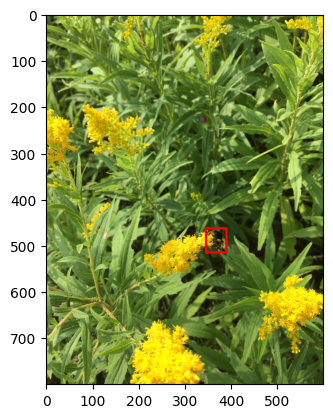

In [ ]:
plt.figure()
for ind1,ele1 in enumerate(paths):
  ele = ele1.split('/')[-2]
  if 'bombus' in ele.lower():
    in1 = cv.imread(ele1)[:,:,::-1].astype(np.uint8)
    sz1 = in1.shape
    v1 = (int(x1[ind1]*sz1[1]),int(y1[ind1]*sz1[0]))
    v2 = (int(x2[ind1]*sz1[1]),int(y2[ind1]*sz1[0]))
    c1 = (255,0,0)
    th = 3
    cv.rectangle(in1,v1,v2,c1,th)
    plt.imshow(in1)
    break

In [ ]:
#class, x1, y1, width, height

In [ ]:
if os.path.isdir('/content/images/train/') is False:os.makedirs('/content/images/train/')
if os.path.isdir('/content/labels/train/') is False:os.makedirs('/content/labels/train/')


for ele in annotations:
  in1 = open('/content/labels/train/'+ele.split('/')[-1].split('.')[0]+'.txt','w')
  for ann in annotations[ele]:
    tLine= '0 %s %s %s %s\n'%(ann[0],ann[1],ann[2],ann[3])
    in1.write(tLine)
  in1.close()
  shutil.copyfile(ele,'/content/images/train/'+ele.split('/')[-1])

In [ ]:
if os.path.isdir('/content/images/val/') is False:os.makedirs('/content/images/val/')
if os.path.isdir('/content/labels/val/') is False:os.makedirs('/content/labels/val/')


for ele in annotationsV:
  if os.path.isfile('/content/labels/val/'+ele.split('/')[-1].split('.')[0]+'.txt') is True:
    in1 = open('/content/labels/val/'+ele.split('/')[-1].split('.')[0]+'.txt','a')
  else:
    in1 = open('/content/labels/val/'+ele.split('/')[-1].split('.')[0]+'.txt','w')
  for ann in annotationsV[ele]:
    tLine= '0 %s %s %s %s\n'%(ann[0],ann[1],ann[2],ann[3])
    in1.write(tLine)
  in1.close()
  shutil.copyfile(ele,'/content/images/val/'+ele.split('/')[-1])

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.7/107.7 GB disk)


In [ ]:
# Validate YOLO11n on COCO8 val
!yolo val model=yolo11n.pt data=coco8.yaml

In [ ]:
#@title Select YOLO11 🚀 logger {run: 'auto'}
logger = 'TensorBoard' #@param ['Comet', 'TensorBoard']

if logger == 'Comet':
  %pip install -q comet_ml
  import comet_ml; comet_ml.init()
elif logger == 'TensorBoard':
  %load_ext tensorboard
  %tensorboard --logdir .

In [ ]:
from ultralytics import YOLO

# Load a model
#model = YOLO('yolo11n.yaml')  # build a new model from scratch
model = YOLO('yolo11n.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data='/content/sicb.yaml', epochs=3)  # train the model
#results = model.val()  # evaluate model performance on the validation set
#results = model('https://ultralytics.com/images/bus.jpg')  # predict on an image
#results = model.export(format='onnx')  # export the model to ONNX format

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/sicb.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

train: Scanning /content/labels/train... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:01<00:00, 299.63it/s]

train: New cache created: /content/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/labels/val... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 349.71it/s]

val: New cache created: /content/labels/val.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.473       2.87      1.696         34        640: 100%|██████████| 27/27 [06:39<00:00, 14.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:28<00:00,  9.56s/it]

                   all         90         90      0.003        0.9      0.428      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      1.437      2.186      1.606         46        640: 100%|██████████| 27/27 [06:50<00:00, 15.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:28<00:00,  9.49s/it]

                   all         90         90      0.453      0.332      0.385      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.467      2.147      1.636         26        640: 100%|██████████| 27/27 [06:34<00:00, 14.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:29<00:00,  9.85s/it]

                   all         90         90      0.737      0.433      0.662      0.364



3 epochs completed in 0.359 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:28<00:00,  9.48s/it]


                   all         90         90      0.754      0.444      0.663      0.364
Speed: 5.9ms preprocess, 275.9ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
results = model.export(format='onnx')  # export the model to ONNX format

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 212.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 234.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 191.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 237.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 10.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to t

In [ ]:
!pip install -U jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [ ]:
results = model.export(format='tflite')  # export the model to ONNX format

In [ ]:
import pickle

In [ ]:
in1 = open('/content/annotations','wb')
pickle.dump([annotations,annotationsV],in1)
in1.close()

In [ ]:
model = YOLO('/content/runs/detect/train2/weights/best.pt')

In [ ]:
rsts = model('/content/t8_00955.jpg')


image 1/1 /content/t8_00955.jpg: 480x640 (no detections), 236.8ms
Speed: 5.8ms preprocess, 236.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
rsts[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: (1944, 2592)
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))